# ***Modelo Transformers***

## **Librerías y carga de datos**


In [1]:
!pip install transformers
!pip install datasets
!pip install torch
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import torch, pickle, os
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#root_dir = r"/content/drive/MyDrive/aaa/"
#root_dir = r"/content/drive/MyDrive/Proyecto-de-Grado-RAD-Alert/Oficial/Ahora-si-este-fue/data/"
root_dir = '/content/drive/MyDrive/PDG/data/'
export_dir = '/content/drive/MyDrive/PDG/models/'

In [5]:
path_train = root_dir + "train_oversample_df.xlsx"
path_val = root_dir + "val_df.xlsx"

In [6]:
df_train = pd.read_excel(path_train)
df_val = pd.read_excel(path_val)

In [7]:
df_train["label"] = df_train["etiqueta"]
df_val["label"] = df_val["etiqueta"]

In [8]:
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)

## **Transformador**

In [9]:
model_name = "PlanTL-GOB-ES/roberta-base-biomedical-clinical-es"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/540k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-biomedical-clinical-es and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Dataset personalizado
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

### Tokenizador

In [11]:
# Crear datasets
train_dataset = TextDataset(df_train['texto'].tolist(), df_train['label'].tolist(), tokenizer)
val_dataset = TextDataset(df_val['texto'].tolist(), df_val['label'].tolist(), tokenizer)

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

In [12]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df_train['label']),
    y=df_train['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [14]:
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 15
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [15]:
best_recall = 0.0  # Para guardar el mejor modelo
threshold = 0.3    # Ajustable según necesidad

## **Entrenar Modelo**

In [16]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
class_weights = class_weights.to(device)

# Redefinir el criterio en el dispositivo
criterion = nn.CrossEntropyLoss(weight=class_weights)

best_recall = 0.0  # Para guardar el mejor modelo
threshold = 0.3    # Umbral ajustado para favorecer recall

# Loop de entrenamiento
model.train()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    epoch_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Loss promedio en epoch {epoch+1}: {avg_loss:.4f}")


Epoch 1/15
Loss promedio en epoch 1: 0.2233

Epoch 2/15
Loss promedio en epoch 2: 0.1133

Epoch 3/15
Loss promedio en epoch 3: 0.0760

Epoch 4/15
Loss promedio en epoch 4: 0.0464

Epoch 5/15
Loss promedio en epoch 5: 0.0286

Epoch 6/15
Loss promedio en epoch 6: 0.0195

Epoch 7/15
Loss promedio en epoch 7: 0.0130

Epoch 8/15
Loss promedio en epoch 8: 0.0106

Epoch 9/15
Loss promedio en epoch 9: 0.0033

Epoch 10/15
Loss promedio en epoch 10: 0.0058

Epoch 11/15
Loss promedio en epoch 11: 0.0023

Epoch 12/15
Loss promedio en epoch 12: 0.0010

Epoch 13/15
Loss promedio en epoch 13: 0.0003

Epoch 14/15
Loss promedio en epoch 14: 0.0003

Epoch 15/15
Loss promedio en epoch 15: 0.0002


## **Evaluar Modelo**

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [18]:
# Evaluación
model.eval()
all_preds = []
all_labels = []

In [19]:
with torch.no_grad():
      for batch in val_loader:
          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          probs = torch.softmax(outputs.logits, dim=1)
          preds = (probs[:, 1] >= threshold).long()

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

In [20]:
# Métricas
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

print(f"\n📊 Métricas de evaluación:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")



📊 Métricas de evaluación:
Accuracy:  0.9287
Precision: 0.7895
Recall:    0.8468
F1-score:  0.8171


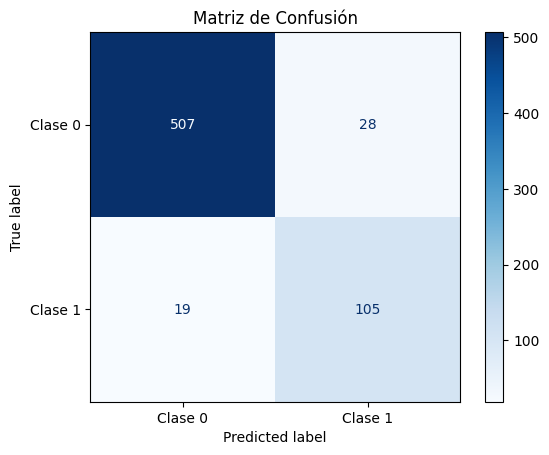

In [21]:
# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clase 0", "Clase 1"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

## **Exportar Modelo**